In [ ]:
!pip install qutip

     |████████████████████████████████| 14.8 MB 15.8 MB/s 


In [ ]:
#Import libraries 
import qutip as qt
import numpy as np
from numpy import linalg
import scipy as spy
import itertools
import matplotlib.pyplot as plt
from qutip.qip.operations import swap

System Hamiltonian

$H = H_S + H_B + H_{SB}$,

where

\begin{align}
  H_S &= \omega d^{\dagger}d + i \sum_{1\leq a <b}^{2N} K_{ab} \Psi_a \Psi_b\\  &+ \sum_{n=1}^N  \frac{g}{2}\big[ 
    ( \Psi_{2n-1}- i \Psi_{2n}) d + d^{\dagger}( \Psi_{2n-1}+ i \Psi_{2n})   \big],\\
    H_B&= \sum_m \omega_m b_m^{\dagger}b_m.\\
    H_{SB} &= \sum_{n=1}^{N} \sum_m g_m  ( \Psi_{2n-1}- i \Psi_{2n}) b_m +g_m^* b_m^{\dagger}( \Psi_{2n-1}+ i \Psi_{2n})
\end{align}
 $\Psi_a$ are Majorana fermions obeying the algebra
$\{ \Psi_a,\Psi_b\}  = 2\delta_{ab}$. Diagonalizing the skew matrix $K_{ab}$, we obtain
\begin{equation}
     H_S^ \;= \omega d^{\dagger}d +  \sum_{n=1}^{N} \lambda_n \chi_{2n-1} \chi_{2n}   + \frac{g}{2}\big[ 
    ( \chi_{2n-1}-i \chi_{2n}) d + d^{\dagger}( \chi_{2n-1}+i \chi_{2n})   \big].
\end{equation}
Introducing $N$ complex Dirac fermions $c_i (i =1,..,N)$ by 
\begin{eqnarray}
 &\chi_{2j}= \frac{c_j - c_j^{\dagger}}{i}, \\& \chi_{2j-1}=c_j + c_j^{\dagger} \\
     c_j^{\dagger}c_j& = \frac{1}{2} ( 1 +i \chi_{2j-1} \chi_{2j}),
\end{eqnarray}
we obtain 

\begin{equation}
     H_S = \omega d^{\dagger}d +  \sum_{n=1}^{N} \lambda_n (2c_n^{\dagger}c_n -1)   + g( c_n^{\dagger} d + d^{\dagger}c_n ),
\end{equation}

\begin{equation}
    H_{SB} = \sum_{n=1}^{N} \sum_m g_m c_n^{\dagger}b_m 
    + g_m^*b_m^{\dagger}c_n. 
\end{equation}

Rewriting $H_S$ in matrix form we observe that

\begin{equation}
H_s = \begin{pmatrix}
d^{\dagger} \;c^{\dagger}
\end{pmatrix}M
\begin{pmatrix}
d\\
c
\end{pmatrix}
\end{equation}
where $c=\sum_{n=1}^N c_n $ and 
\begin{equation}
    M= \begin{pmatrix}
    w& g & ...&g\\
    g&\lambda_1&\dots &0\\
    \vdots &\vdots &\ddots & \vdots\\
    g& 0 &\dots &\lambda_n
    \end{pmatrix}.
\end{equation}

The eigenvalues of M are given by the zeros of the following characteristic polynomial
\begin{equation}
    (w-\epsilon) \Pi_{n=1}^N (\lambda_n - \epsilon) - g^2 \sum_{P_\alpha}\Pi_{\alpha } (\lambda_\alpha -\epsilon) =0.
\end{equation}
Using these eigenvalues we can rewrite the system Hamiltonian as

$H_S = \sum_i  \epsilon_i \xi_i^\dagger \xi_i$,\begin{eqnarray}
&\xi_n  = \frac{1}{|| \xi_n||} \begin{pmatrix}
    d & c_1 &\dots & c_N
    \end{pmatrix}
    \begin{pmatrix}
    1\\
    \frac{g}{\lambda_1 -\epsilon_n }\\
    \vdots\\
    \frac{g}{\lambda_N -\epsilon_n }  
    \end{pmatrix}\;, n = 0,\dots,N \; ,
\end{eqnarray}

\begin{equation}
    || \xi_n|| = \left( 1 + g^2\sum_i \frac{1}{(\lambda_i-\epsilon_n)^2}\right)^{-1/2},
\end{equation}    
satisfying canonical commutation relations
\begin{eqnarray}
    \{ \xi_i, \xi_j^{\dagger}\} = \delta_{ij} ,\:& \{ \xi_i, \xi_j\} = 0.
\end{eqnarray}


In [ ]:
def anticommutator(a, b):
    return a*b + b*a
#########################################################################################

def fermion_operators(n):
    return [qt.tensor(*[qt.destroy(2) if i == j\
                else (qt.sigmaz() if j < i\
                    else qt.identity(2))\
                        for j in range(n)])\
                            for i in range(n)]

def test_fermion_operators(f):
    for i in range(len(f)):
        for j in range(len(f)):
            d = f[i].shape[0]
            #convert to array .full()
            test1 = anticommutator(f[i], f[j]).full()
            test2 = anticommutator(f[i], f[j].dag()).full()
            if not \
                (np.isclose(test1, np.zeros((d,d))).all()\
                    and \
                ((np.isclose(test2, np.zeros((d,d))).all() and i != j)\
                        or (np.isclose(test2, np.eye(d)).all() and i == j))):
                return False
    return True

#########################################################################################



In [ ]:
# non-diagonalized Hamiltonian

def Hamiltonian(w, g, N, gamma, beta, c_fermi):
  
  n= N//2 # complex fermions number
  wg = np.zeros(n+1)
  wg[0] = w/2 # isolated fermion energy
  wg[1:]= g   # interaction strength

  #random interaction matrix 
  K = np.random.randn(N,N) 
  K = 0.5*(K - K.T)

  # K_ab eigenenergies
  lbd= np.linalg.eigvals(K)
  lbd=[np.imag(lbd)[x] for x in range(0,len(lbd),2)]

  #define M
  M=np.zeros((n+1)**2)
  M= M.reshape(n+1,n+1)
  M[0]= wg
  for x in range(n): 
    M[x+1][x+1] =lbd[x]/2
  M = M + M.T
  epsilon = np.linalg.eigvals(M)

  #coupling constants
  norms= np.sqrt([1+g**2*sum(1/(lbd[i]-epsilon[j])**2 for i in range(len(lbd))) for j in range(len(epsilon))])
  random_c = np.array([1+g*sum(1/(lbd[i]-epsilon[j]) for i in range(len(lbd))) for j in range(len(epsilon))])
  random_c = (random_c/norms)**2
  random_cps = [N*gamma*(1+np.tanh(0.5*beta*epsilon[i]))*random_c[i] for i in range(len(random_c))]

  # diagonalized Hamiltonian
  H_d = sum([ epsilon[i]*(c_fermi[i].dag()*c_fermi[i]) for i in range(n)]) 
  return H_d, epsilon, lbd, random_cps, norms



In [ ]:

def solve1(coupl_c,times,c_fermi,N,H, norms):

  #jump operators
  J_op = [np.sqrt(coupl_c[i])*c_fermi[i] for i in range(N//2+1)]
  J_opdag=[J_op[j].dag() for j in range(len(J_op))]
  J_ops = J_op.append(J_opdag)
  #central fermion anihilation operator
  d = [c_fermi[i]/norms[i] for i in range(N//2+1)]
  D = sum(d)
  D_op= D.dag()*D
  #collapse operators
  C_op= [J_op[i].dag()*J_op[i] for i in  range(N//2+1)]

  #initial state
  psi_0 =qt.tensor(*[qt.basis(2,1) for j in range(N//2+1)])
  

  #evolve and calculate expectation values for each quasi-fermion,d 
  out= qt.mesolve(H, psi_0, times, J_op, C_op)
  out_d = qt.mesolve(H, psi_0, times, J_op, D_op)
  rho= qt.mesolve(H, psi_0, times, J_op, [])
  return out, out_d, rho


In [ ]:
# Exponential series solution 
def solve2(H,c_fermi,coupl_c,N):
  
  # jump operators
  J_op = [np.sqrt(coupl_c[i])*c_fermi[i] for i in range(N//2+1)]
  J_opdag=[J_op[j].dag() for j in range(len(J_op))]

  # Liouvillian
  L = qt.liouvillian(H,J_op) 

  #initial state
  rho0= qt.tensor(*[qt.basis(2,1) for j in range(N//2+1)])
  rho0= qt.ket2dm(rho0)

  #solution as an exponential series
  rhoES = qt.ode2es(L,rho0)

  # calculate expectation values 
  counts = [qt.esval(qt.expect(J.dag()*J ,rhoES),times)for J in J_op]

  return counts 


In [ ]:
#System variables

N= 14 # Majorana fermions number
f= fermion_operators(N//2+1) # Complex fermions anihilation operators
w= 1e-1
g= w*(1/0.06)
gamma= 1e-1
beta = gamma*1e2
times = np.linspace(0.0, 10, 120)
x = np.arange(1,9)
##################################################

#Calculate the time evolution of the system

purity=[]
entropy=[]
H, eps, lamb, coupl_c,  quasi_norms = Hamiltonian(w, g, N, gamma, beta, f)
eps = np.sort(eps)

result_q, result_d, rho = solve1(coupl_c, times, f, N, H, quasi_norms )
counts_q= result_q.expect
counts_d= result_d.expect
rhot = rho.states
purity_min = [1/2**(N//2+1)]*len(rhot)
entropy_max= [np.log(2**(N//2+1))]*len(rhot)
d_min = [min(counts_d[0])]*len(rhot)

for i in range(len(rhot)):
    # purity
    purity.append((rhot[i]**2).tr())
    #entropy
    entropy.append(qt.entropy_vn(rhot[i]))
##################################################
#Plot populations of the quasiparticles



Text(0, 0.5, 'eigenenergies')

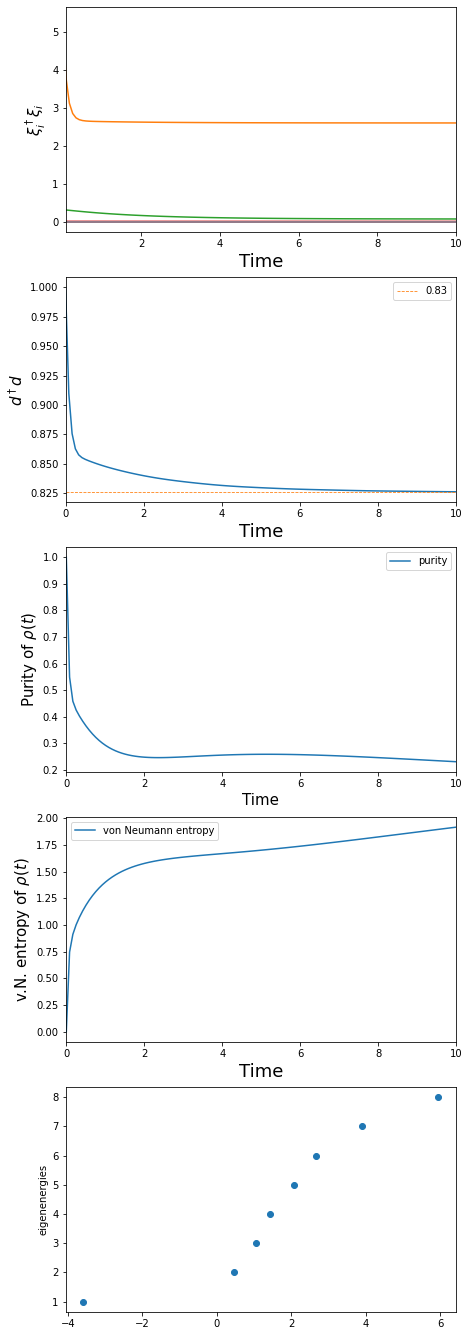

In [ ]:
fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(5,1, figsize=(7,24))


for count in counts_q:
  ax1.plot(times, np.real(count), '-')
ax1.set_xlabel('Time', fontsize=18)
ax1.set_ylabel(r'$\xi_i^\dagger\xi_i$', fontsize=15)
#ax1.set_ylim(-0.01,1)
ax1.set_xlim(0.07,max(times))

# Central electron population
ax2.plot(times,np.real(counts_d[0]), '-')
ax2.plot(times,np.real(d_min), '--', label="%.2f"%(d_min[0]),linewidth=0.8)
ax2.set_xlabel('Time', fontsize=18)
ax2.set_ylabel(r'$d^\dagger d$', fontsize=15)
ax2.set_xlim(0,10)
ax2.legend()

#Purity of the system
ax3.plot(times,purity,label="purity")
#ax3.plot(times,purity_min,label="minimum purity")
ax3.set_xlim(-0.02,max(times))
ax3.set_xlabel('Time', fontsize=15)
ax3.set_ylabel("Purity of $\\rho(t)$", fontsize=15)
ax3.legend()

#Entropy of the system
ax4.plot(times,entropy,label="von Neumann entropy")
ax4.set_xlim(-0.02,max(times))
#ax4.plot(times,entropy_max,label="maximum entropy")
ax4.set_xlabel('Time', fontsize=18)
ax4.set_ylabel("v.N. entropy of $\\rho(t)$", fontsize=15)
ax4.legend()

#Eigenenergies of the system
ax5.scatter(eps,x)
ax5.set_ylabel("eigenenergies")


In [ ]:
#MWabala mesoscopic system 
#system variables
#################################################

w=3
N=500
e= 1
g= 1
theta= 0.5*np.arctan((2*g*np.sqrt(N))/(w-e))
Omega_N= np.sqrt(4*N*g**2+ (w-e)**2)
gamma= 1
beta= 1
c_fermions = fermion_operators(2)
times = np.linspace(0.0, 1e-2, 100)
c0= c_fermions[0]
c1= c_fermions[1]

#eigen energies

ld0= 0.5*(w+e) + 0.5*Omega_N
ld1= 0.5*(w+e) - 0.5*Omega_N

# Colapse operators

e0 =np.sqrt(N*gamma*(1+np.tanh(0.5*beta*ld0))*(np.sin(theta))**2)*c0
e1 =np.sqrt(N*gamma*(1+np.tanh(0.5*beta*ld1))*(np.cos(theta))**2)*c1
e0_s= np.sqrt(N*gamma*(1-np.tanh(0.5*beta*ld0))*(np.sin(theta))**2)*c0
e1_s= np.sqrt(N*gamma*(1-np.tanh(0.5*beta*ld1))*(np.cos(theta))**2)*c1
E0=e0.dag()*e0
E1=e1.dag()*e1
H= c0.dag()*c0*ld0+ c1.dag()*c1*ld1

#################################################
id=qt.tensor(qt.basis(2,0),qt.basis(2,0))
id1= qt.fock(4,1)
psi_0= np.cos(theta)*c0*id -np.sin(theta)*c1*id

#qt.tensor(qt.basis(2,0),qt.basis(2,0)).full

In [ ]:
def solveMwala(times, c_fermions, theta, gamma, beta, Omega_N, N):
  
  id= qt.tensor(qt.basis(2,1),qt.basis(2,1))
  # quasifermionic operators

  c0= c_fermions[0]
  c1= c_fermions[1]
  #eigen energies

  ld0= 0.5*(w+e) + 0.5*Omega_N
  ld1= 0.5*(w+e) - 0.5*Omega_N
  # Colapse operators

  e0 =np.sqrt(N*gamma*(1+np.tanh(0.5*beta*ld0))*(np.sin(theta))**2)*c0
  e1 =np.sqrt(N*gamma*(1+np.tanh(0.5*beta*ld1))*(np.cos(theta))**2)*c1
  e0_s= np.sqrt(N*gamma*(1-np.tanh(0.5*beta*ld0))*(np.sin(theta))**2)*c0
  e1_s= np.sqrt(N*gamma*(1-np.tanh(0.5*beta*ld1))*(np.cos(theta))**2)*c1
  E0=e0.dag()*e0
  E1=e1.dag()*e1
  E0_s=e0_s.dag()*e0_s
  E1_s=e1_s.dag()*e1_s
  #Hamiltonian

  H= c0.dag()*c0*ld0+ c1.dag()*c1*ld1

  #initial state

  psi_0= np.cos(theta)*c0*id -np.sin(theta)*c1*id
  d= np.cos(theta)*c0 -np.sin(theta)*c1
  #evolve and calculate expectation values for each quasi-fermion
  out= qt.mesolve(H, id, times, [e0, e0.dag(), e1, e1.dag(), e0_s, e0_s.dag(), e1_s, e1_s.dag()], [d.dag()*d])
  out1 = qt.mesolve(H, id, times, [e0,e0.dag(), e1, e1.dag(), e0_s, e0_s.dag(), e1_s, e1_s.dag()], [])
  return out.expect, out1


In [ ]:
count_mwalaba, result= solveMwala(times, c_fermions, theta, gamma, beta, Omega_N, N)
count_mwalaba
rhot =result.states
purity=[]
for i in range(len(rhot)):
    # inefficient method
    purity.append((rhot[i]**2).tr())



(0.0, 0.01)

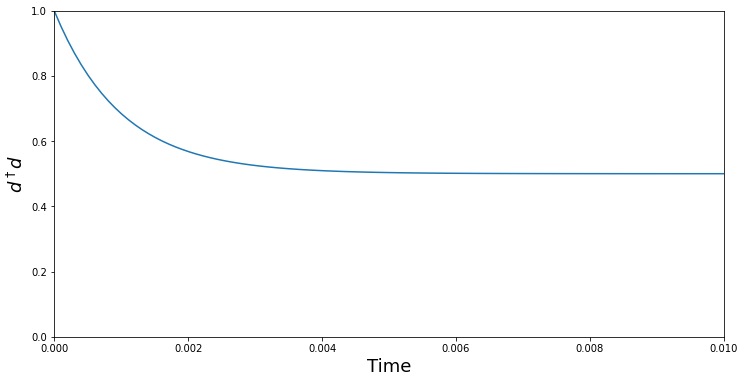

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
for count in count_mwalaba:
  ax.plot(times, np.real(count), '-')
ax.set_xlabel('Time', fontsize=18)
ax.set_ylabel(r'$d^\dagger d$', fontsize=18)
ax.set_ylim(0,1)
ax.set_xlim(0,max(times))